Questo codice esegue operazioni per la classificazione di generi musicali. Si tratta di un problema di classificazione single-label multiclasse, in cui ogni canzone è associata a un unico genere musicale. Tuttavia, questa rappresentazione costituisce un'approssimazione della realtà, poiché i brani possono appartenere a più generi contemporaneamente.

Si segnala, inoltre, che per eseguire il codice è necessario aggiornare i link di Google Drive.

#librerie e import drive

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
# File management and OS
import os
import shutil
import random
import tarfile
from shutil import copyfile
from google.colab import drive

# Data manipulation and analysis
import numpy as np
import pandas as pd
from collections import Counter
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd  # Notebook only
from librosa.display import specshow

# Audio and Signal Processing
import librosa
from scipy.io import wavfile as wav
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
import soundfile as sf

# Machine Learning and Classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier


# Neural Networks and Deep Learning (TensorFlow, Keras)
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner

# Utilities
import joblib
import wave
import math
from IPython.display import Audio
from scipy.io import wavfile

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Visualizzazione audio completo

Questo segmento di codice esegue una serie di operazioni di analisi su un file audio per estrarre informazioni utili e verificarne la qualità. Prima di tutto, carica un file audio e ne esamina le caratteristiche principali, come il tasso di campionamento originale e la durata del brano. Successivamente, calcola il rapporto segnale/rumore (SNR) per determinare se l'audio contiene rumore, confrontando la potenza del segnale con la potenza del rumore. Vengono anche estratte informazioni aggiuntive sul file, come il numero di canali (mono o stereo) e la profondità in bit, per avere un quadro completo delle sue proprietà tecniche. Infine, visualizza una rappresentazione del segnale audio in formato onda, utile per un'analisi visiva.

In [ ]:
random_file_name = "/content/gdrive/MyDrive/Digital progetto/Data/Data_extracted/genres_original/blues/blues.00000.wav"
y,sr = librosa.load(random_file_name,sr=None)

In [ ]:
sr_original = librosa.get_samplerate(random_file_name)
print(f"Original Sample Rate: {sr_original} Hz")

Original Sample Rate: 22050 Hz


In [ ]:
print(f"Audio duration: {len(y) / sr} seconds")

Audio duration: 30.013333333333332 seconds


In [ ]:
y.shape

(661794,)

In [ ]:
data_dir="/content/gdrive/MyDrive/Digital progetto/Data/Data_extracted/genres_original"
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [ ]:
Audio(data=y,rate=sr)

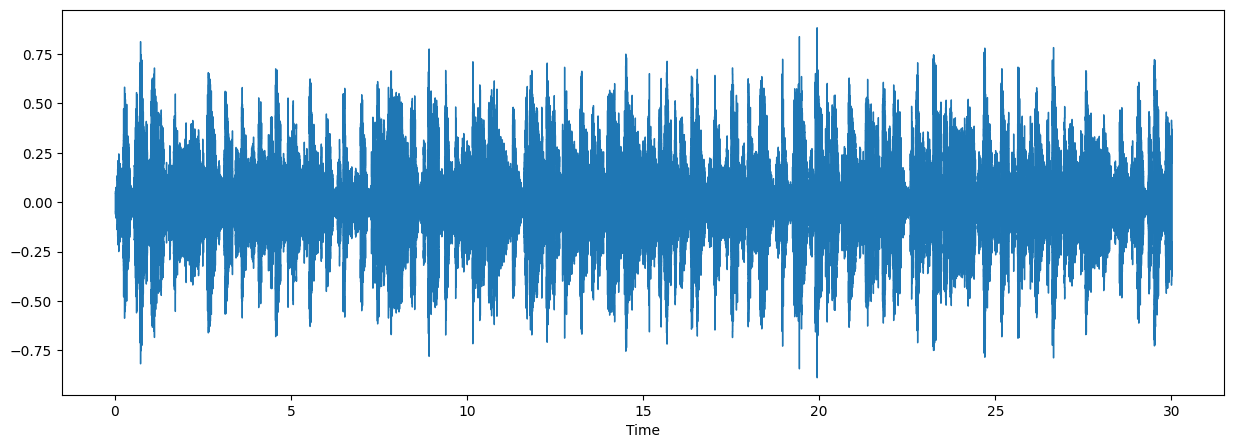

In [ ]:
plt.figure(figsize=(15,5))
librosa.display.waveshow(y,sr=sr)

In [ ]:
def calculate_snr(y, noise_threshold=0.01):
    # Stima del rumore come la parte a basso livello di energia del segnale
    noise = y[np.abs(y) < noise_threshold]
    signal_power = np.mean(y ** 2)
    noise_power = np.mean(noise ** 2) if len(noise) > 0 else 1e-10
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Calcola il SNR
snr_value = calculate_snr(y)
print(f"SNR: {snr_value:.2f} dB")

# Soglia indicativa: SNR < 20 dB=  probabile rumore
if snr_value < 20:
    print("Rumore presente")
else:
    print("file  pulito.")


SNR: 27.80 dB
file  pulito.


In [ ]:
info = sf.info(random_file_name)
print(info)

if info.channels == 1:
    print("mono.")
else:
    print("stereo.")

subtype = info.subtype
if "16" in subtype:
    print("16-bit.")
else:
    print(f" NON è  16-bit, è {subtype}.")


/content/gdrive/MyDrive/Digital progetto/Data/Data_extracted/genres_original/blues/blues.00000.wav
samplerate: 22050 Hz
channels: 1
duration: 30.013 s
format: WAV (Microsoft) [WAV]
subtype: Signed 16 bit PCM [PCM_16]
mono.
16-bit.


#Feauture extraction e loader

I seguenti segmenti di codice implementano
 1. una funzione per l'estrazione delle caratteristiche audio da un file WAV,
 utilizzando la libreria librosa. La funzione extract_features estrae una serie di feature che descrivono il contenuto spettrale e temporale del segmento audio. Le caratteristiche includono misure come la crominanza, la frequenza media, la banda spettrale, il roll-off spettrale, e il tasso di attraversamento dello zero (Zero Crossing Rate). Inoltre, vengono estratti anche i coefficienti MFCC (Mel-Frequency Cepstral Coefficients) e il tempo del brano. Ogni caratteristica viene poi rappresentata da media e varianza, che permettono di catturare le informazioni sia sul comportamento centrale che sulla dispersione del segnale audio.

2. Un ulteriore segmento di codice riguarda il caricamento dei dati in batch da una directory, con la possibilità di normalizzare le caratteristiche tramite uno scaler standard, e di suddividere il dataset in set di addestramento e test. La funzione load_data_in_batches è progettata per processare grandi quantità di file audio in modo efficiente, caricando i file di ciascuna classe in batch, estraendo le feature audio per ciascuno di essi, e restituendo i dati in un formato adatto per l'addestramento di modelli di machine learning.

In [ ]:
def extract_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None, mono=True, duration=3)
    # Caratteristiche spettrali
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # media e varianza
    features = [
        np.mean(chroma), np.var(chroma),
        np.mean(rms), np.var(rms),
        np.mean(spectral_centroid), np.var(spectral_centroid),
        np.mean(spectral_bandwidth), np.var(spectral_bandwidth),
        np.mean(rolloff), np.var(rolloff),
        np.mean(zcr), np.var(zcr),
        librosa.beat.tempo(y=y, sr=sr)[0],  # tempo
    ]

    # Aggiungi le caratteristiche MFCC
    for i in range(n_mfcc):
        features.append(np.mean(mfccs[i]))
        features.append(np.var(mfccs[i]))

    return np.array(features)

In [ ]:
file_path = "/content/gdrive/MyDrive/Digital progetto/Data/data_crop/blues/blues.00000_crop_0.wav"
features = extract_features(file_path)

print(features)

[ 3.35555166e-01  9.09966901e-02  1.30189195e-01  3.55880824e-03
  1.77335800e+03  1.69450830e+05  1.97233426e+03  1.17272641e+05
  3.71406344e+03  1.08317945e+06  8.18509615e-02  5.57687240e-04
  1.29199219e+02 -1.19018044e+02  2.49444531e+03  1.25080353e+02
  2.62113098e+02 -2.33943329e+01  3.65394104e+02  4.13217316e+01
  1.81913040e+02 -5.93189621e+00  1.52475174e+02  2.00927505e+01
  7.53739395e+01 -1.60315228e+01  4.00679932e+01  1.78110237e+01
  8.48437653e+01 -1.46437750e+01  8.33371658e+01  1.02183104e+01
  9.60625153e+01 -9.70155239e+00  6.65951920e+01  1.01689796e+01
  4.52569046e+01 -4.67266846e+00  3.42402077e+01]


In [ ]:
def load_data_in_batches(data_dir, classes, feature_extractor, batch_size=50, normalize=False, test_size=0.2, random_state=42):
    labels = []
    features = []
    scaler = StandardScaler()

    # Itera su ogni classe e carica i file in batch
    for label_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        files = sorted(os.listdir(class_dir))

        for i in range(0, len(files), batch_size):
            batch_files = files[i:i+batch_size]
            batch_features = []
            batch_labels = []
            print(f"Caricando classe: {class_name} ({label_idx}), files {i} - {i + len(batch_files)}")

            for f in batch_files:
                if f.endswith('.wav'):
                    file_path = os.path.join(class_dir, f)
                    cur_features = feature_extractor(file_path)
                    batch_features.append(cur_features)
                    batch_labels.append(label_idx)

                    print(f"File: {f} - Classe: {class_name} ({label_idx})")

            features.extend(batch_features)
            labels.extend(batch_labels)

    features_df = pd.DataFrame(features)

    # Divisione dei dati in train e test
    X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=test_size, random_state=random_state)

    # Normalizzazione se richiesta
    if normalize:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    joblib.dump(scaler, "scaler.pkl")

    return X_train, X_test, y_train, y_test


#CLASSIFICATION CON AUDIO COMPLETO

In [ ]:
DATASET_PATH = "/content/gdrive/MyDrive/Digital progetto/Data/Data_extracted/genres_original"
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

X_train_or, X_test_or, y_train_or, y_test_or = load_data_in_batches(DATASET_PATH, GENRES, extract_features)

global scaler
scaler = StandardScaler()
X_train_or = scaler.fit_transform(X_train_or)
X_test_or = scaler.transform(X_test_or)


joblib.dump(scaler, "scaler.pkl")
joblib.dump(X_train_or, "X_train_or.pkl")
joblib.dump(X_test_or, "X_test_or.pkl")
joblib.dump(y_train_or, "y_train_or.pkl")
joblib.dump(y_test_or, "y_test_or.pkl")

SVM

In [ ]:
def plot_cm(model_name, y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
param_grid = {'C': [1, 10, 50, 100, 200, 300, 1000],
              'gamma': [0.001, 0.01, 0.1, 1]}

clf = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid, cv=StratifiedKFold(n_splits=3))

t0 = time.time()
clf.fit(X_train_or, y_train_or)
print(f'Training completed in {time.time() - t0:.3f}s')

best_model = clf.best_estimator_
best_score = clf.best_score_
print(f'Best model found with score: {best_score:.3f}')
print(f'Best parameters: C={best_model.C}, gamma={best_model.gamma}')

joblib.dump(best_model, 'best_svm_model_or.pkl')
print('Best SVM model saved as best_svm_model_or.pkl')



Training completed in 18.203s
Best model found with score: 0.622
Best parameters: C=10, gamma=0.01
Best SVM model saved as best_svm_model.pkl


Training Accuracy: 0.9072681704260651
Classification Report for Best SVM Model:
              precision    recall  f1-score   support

           0       0.55      0.52      0.54        21
           1       0.69      0.92      0.79        12
           2       0.74      0.74      0.74        23
           3       0.50      0.61      0.55        23
           4       0.62      0.67      0.65        15
           5       0.79      0.70      0.75        27
           6       0.60      0.67      0.63        18
           7       0.68      0.76      0.72        17
           8       0.59      0.45      0.51        22
           9       0.41      0.32      0.36        22

    accuracy                           0.62       200
   macro avg       0.62      0.64      0.62       200
weighted avg       0.62      0.62      0.61       200

Confusion Matrix for Best SVM Model:


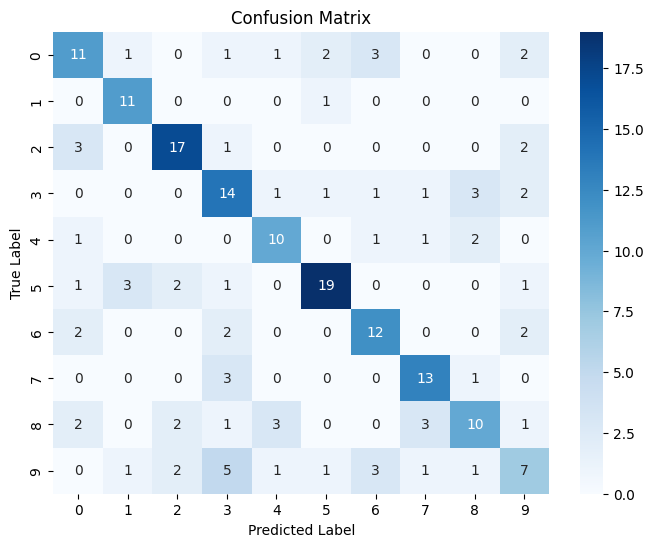

In [ ]:
best_svm_model = joblib.load('best_svm_model_or.pkl')

y_pred_test = best_svm_model.predict(X_test_or)
y_train_pred = best_svm_model.predict(X_train_or)

train_accuracy = accuracy_score(y_train_or, y_train_pred)
print("Training Accuracy:", train_accuracy)

#Confusion matrix
cm = confusion_matrix(y_test_or, y_pred_test)
cr = classification_report(y_test_or, y_pred_test)

#Classification report
print("Classification Report for Best SVM Model:")
print(cr)
print("Confusion Matrix for Best SVM Model:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


RANDOM FOREST

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters found:  {'bootstrap': False, 'criterion': 'gini', 'max_features': 3, 'n_estimators': 300}
Random Forest Training Accuracy: 1.00000

Classification Report:
              precision    recall  f1-score   support

       blues       0.40      0.38      0.39        21
   classical       0.61      0.92      0.73        12
     country       0.81      0.74      0.77        23
       disco       0.44      0.48      0.46        23
      hiphop       0.67      0.53      0.59        15
        jazz       0.75      0.67      0.71        27
       metal       0.67      0.67      0.67        18
         pop       0.59      0.76      0.67        17
      reggae       0.61      0.64      0.62        22
        rock       0.59      0.45      0.51        22

    accuracy                           0.61       200
   macro avg       0.61      0.62      0.61       200
weighted avg       0.62      0.61      0.61       200



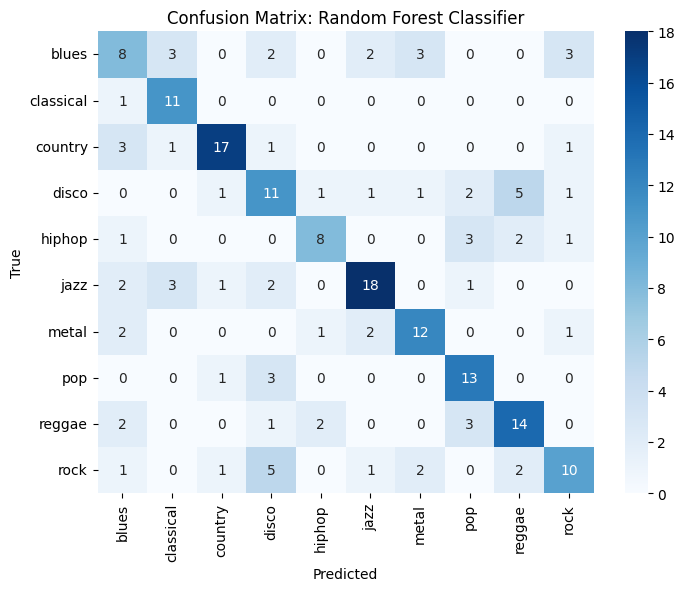

Random Forest model saved as random_forest_model.pkl


In [ ]:
# Define the parameter grid
rf_param_grid = {
    'max_features': [1, 3, 10],
    'bootstrap': [False],
    'n_estimators': [100, 200, 300],
    'criterion': ['gini']
}


rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid=rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_or, y_train_or)

best_rf = grid_search_rf.best_estimator_
print("Best parameters found: ", grid_search_rf.best_params_)

y_train_pred = best_rf.predict(X_train_or)
print(f"Random Forest Training Accuracy: {best_rf.score(X_train_or, y_train_or):.5f}\n")

y_test_pred = best_rf.predict(X_test_or)

# Classification report
print("Classification Report:")
print(classification_report(y_test_or, y_test_pred, target_names=GENRES))

#confusion matrix
plot_cm('Random Forest Classifier', y_test_or, y_test_pred, GENRES)

joblib.dump(best_rf, 'random_forest_model_or.pkl')
print('Random Forest model saved as random_forest_model_or.pkl')


KNN

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'distance'}
KNN Training Accuracy: 1.00000

Classification Report:
              precision    recall  f1-score   support

       blues       0.60      0.29      0.39        21
   classical       0.53      0.83      0.65        12
     country       0.82      0.39      0.53        23
       disco       0.29      0.52      0.38        23
      hiphop       0.67      0.40      0.50        15
        jazz       0.75      0.67      0.71        27
       metal       0.65      0.72      0.68        18
         pop       0.54      0.76      0.63        17
      reggae       0.54      0.59      0.57        22
        rock       0.39      0.32      0.35        22

    accuracy                           0.54       200
   macro avg       0.58      0.55      0.54       200
weighted avg       0.58      0.54      0.53       200



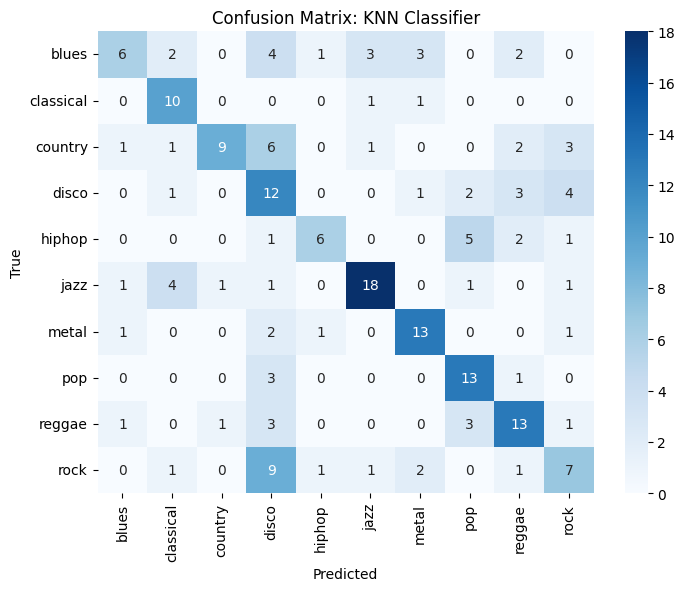

KNN model saved as knn_model.pkl


In [ ]:
# Parameter grid for KNN
knn_param_grid = {
    'n_neighbors': np.linspace(10,15,20, dtype=int).tolist(),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid=knn_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train_or, y_train_or)


best_knn = grid_search_knn.best_estimator_
print("Best parameters found: ", grid_search_knn.best_params_)

y_train_pred = best_knn.predict(X_train_or)
print(f"KNN Training Accuracy: {best_knn.score(X_train_or, y_train_or):.5f}\n")

y_test_pred = best_knn.predict(X_test_or)

# classification report
print("Classification Report:")
print(classification_report(y_test_or, y_test_pred, target_names=GENRES))

# confusion matrix
plot_cm('KNN Classifier', y_test_or, y_test_pred, GENRES)

joblib.dump(best_knn, 'knn_model_or.pkl')
print('KNN model saved as knn_model_or.pkl')

#Divisione in crop

Questo segmento di codice è progettato per elaborare i file segmentandoli in base a una lunghezza specificata, ovvero segmenti da 3 secondi con sovrapposizione di 0.5 secondi. Il processo inizia con la funzione check_length, che si occupa di trincare o aggiungere zeri al segnale audio per garantirne la lunghezza corretta.
Successivamente, la funzione make_crop suddivide il segnale audio in segmenti di lunghezza fissa, creando sovrapposizioni tra i segmenti per garantire una suddivisione precisa e uniforme. Infine, la funzione process_audio esegue la segmentazione per tutti i file audio presenti nella cartella di input, organizzando i segmenti in base al genere musicale e salvando i segmenti risultanti in una cartella di destinazione.
Questo processo è utile per creare dataset di audio segmentati, aumentando la dimensione da 1000 canzoni complete a circa 10mila parti di canzoni.

In [ ]:
def check_length(input, size):
    output = input[0:min(size, input.shape[0])]
    output = np.concatenate((output, np.zeros(size - output.shape[0])))
    return output

def make_crop(audio, new_length=3, rate=None, num_segments=12):
    total_length = len(audio) / rate
    segment_length = new_length
    overlap = 0.5
    step = segment_length - overlap

    lst_crops = []
    start_crop = 0


    for i in range(num_segments):
        end_crop = start_crop + rate * segment_length
        lst_crops.append(audio[int(start_crop):int(end_crop)])
        start_crop = end_crop - rate * overlap

    return lst_crops


def process_audio(path, dest_path, classes, overlap=True, new_length=3, num_segments=12):
    if not os.path.exists(dest_path):
        os.makedirs(dest_path, exist_ok=True)

    for genre in classes:
        genre_path = os.path.join(path, genre)
        genre_dest_path = os.path.join(dest_path, genre)

        if not os.path.exists(genre_dest_path):
            os.makedirs(genre_dest_path)

        for f in sorted(os.listdir(genre_path)):
            if f.endswith('.wav'):
                rate, signal = wavfile.read(os.path.join(genre_path, f))
                # Crea i segmenti audio
                crops = make_crop(signal, new_length=new_length, rate=rate, num_segments=num_segments)

                count = 0
                for c in crops:
                    filename = os.path.join(genre_dest_path, f[:-4] + '_crop_' + str(count) + '.wav')
                    os.makedirs(os.path.dirname(filename), exist_ok=True)
                    wavfile.write(filename, rate, c)
                    count += 1

output_dir = "/content/gdrive/MyDrive/Digital progetto/Data/data_crop"
process_audio(data_dir, output_dir, GENRES, overlap=True, new_length=3, num_segments=12)


#Visualizzazione dati crop

vengono eseguite diverse operazioni per esplorare e visualizzare le caratteristiche audio di un file audio tra quelli creati (audio crop) scelto casualmente dalla cartella di dati. Il flusso di lavoro include il caricamento del file audio, l'estrazione di alcune delle principali feature audio (come Zero Crossing Rate, Root Mean Square Energy, Spectral Centroid e MFCC) e la loro visualizzazione tramite grafici.

In [ ]:
data_dir_crop = "/content/drive/MyDrive/Digital progetto/Data/data_crop"

In [ ]:
random_file_name_crop = "/content/gdrive/MyDrive/Digital progetto/Data/data_crop/blues/blues.00000_crop_0.wav"
sig,sr = librosa.load(random_file_name,sr=None)

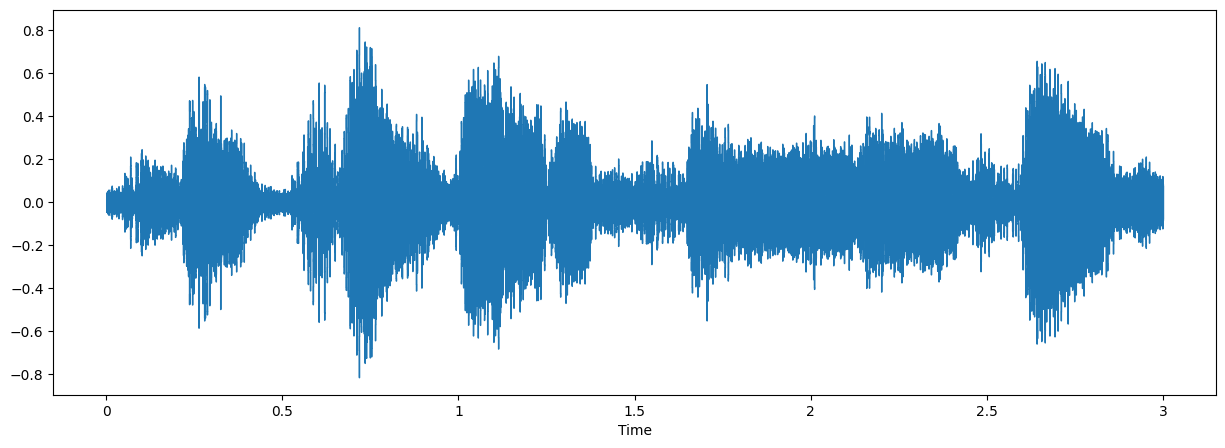

In [ ]:
plt.figure(figsize=(15,5))
librosa.display.waveshow(sig,sr=sr)

In [ ]:
sr

22050

In [ ]:
sig.shape

(66150,)

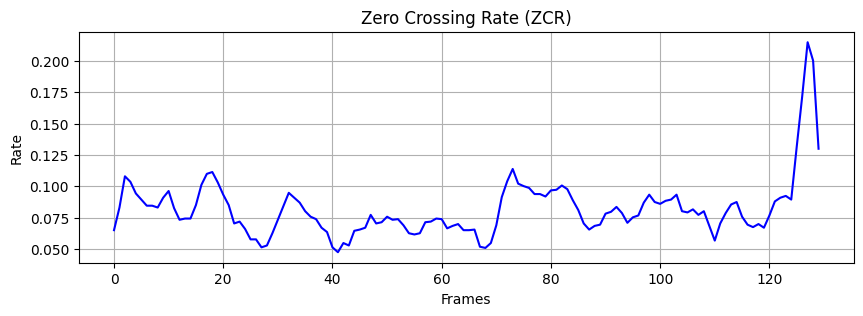

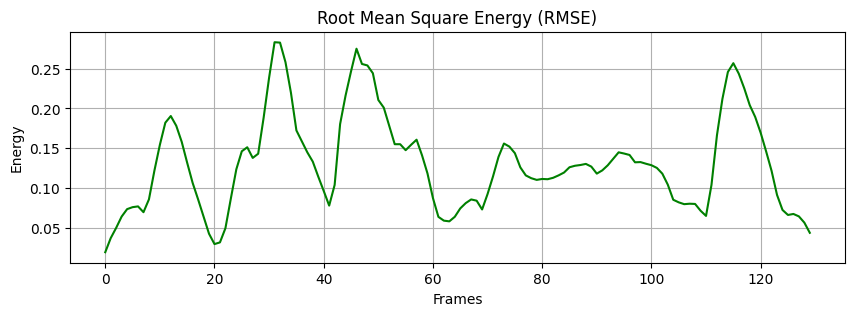

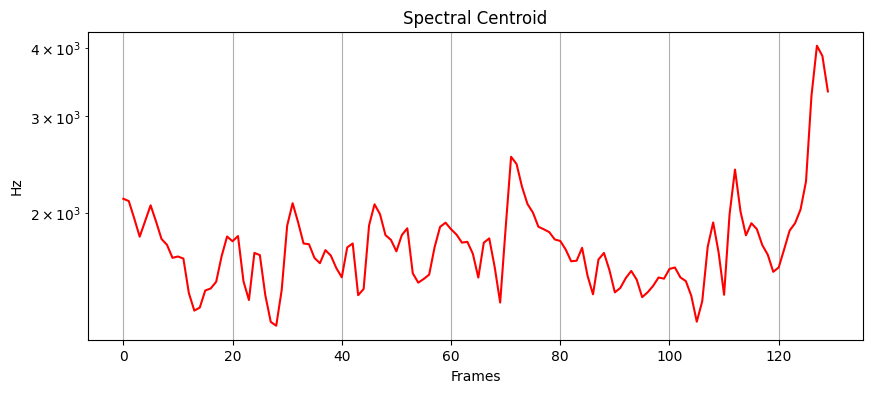

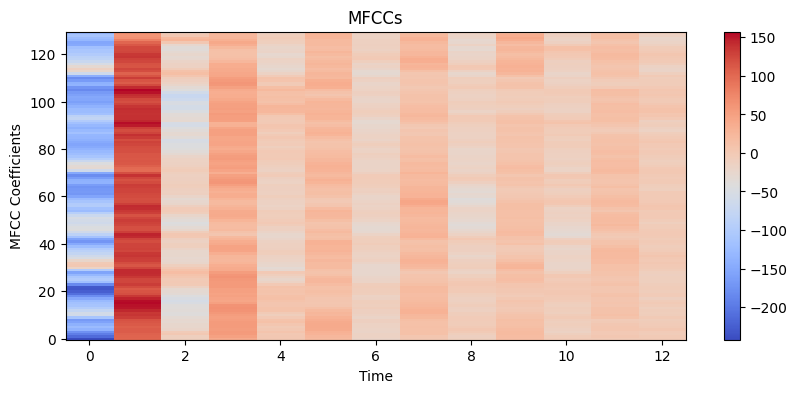

In [ ]:
y, sr = librosa.load(random_file_name_crop, sr=None, mono=True)

zcrs = librosa.feature.zero_crossing_rate(y)
rmse_ = librosa.feature.rms(y=y)
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# 1. Zero Crossing Rate (ZCR)
plt.figure(figsize=(10, 3))
plt.plot(zcrs[0], color='b')
plt.title('Zero Crossing Rate (ZCR)')
plt.xlabel('Frames')
plt.ylabel('Rate')
plt.grid()
plt.show()

# 2. Root Mean Square Energy (RMSE)
plt.figure(figsize=(10, 3))
plt.plot(rmse_[0], color='g')
plt.title('Root Mean Square Energy (RMSE)')
plt.xlabel('Frames')
plt.ylabel('Energy')
plt.grid()
plt.show()

# 3. Spectral Centroid
plt.figure(figsize=(10, 4))
plt.semilogy(spectral_centroids.T, label='Spectral Centroid', color='r')
plt.ylabel('Hz')
plt.xlabel('Frames')
plt.title('Spectral Centroid')
plt.grid()
plt.show()

# 4. MFCCs
fig, ax = plt.subplots(figsize=(10, 4))
mfcc_data = np.swapaxes(mfccs, 0, 1)
cax = ax.imshow(mfcc_data, interpolation='nearest', origin='lower', aspect='auto', cmap='coolwarm')
ax.set_title('MFCCs')
ax.set_xlabel('Time')
ax.set_ylabel('MFCC Coefficients')
fig.colorbar(cax)
plt.show()


#Test e train set

Questo segmento di codice prepara e normalizza i dati audio per l'addestramento di un modello di classificazione del genere musicale. I dati vengono caricati, suddivisi in set di addestramento e test, e le caratteristiche audio vengono estratte. Successivamente, i dati vengono normalizzati utilizzando uno scaler e salvati su disco insieme ai set di dati. Viene anche verificata la dimensione dei dati e stampate le caratteristiche del primo esempio del set di addestramento insieme alla sua etichetta.









In [ ]:
DATASET_PATH = "/content/gdrive/MyDrive/Digital progetto/Data/data_crop"
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

X_train, X_test, y_train, y_test = load_data_in_batches(DATASET_PATH, GENRES, extract_features)

# Normalize per sicurezza
global scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


joblib.dump(scaler, "scaler.pkl")
joblib.dump(X_train, "X_train.pkl")
joblib.dump(X_test, "X_test.pkl")
joblib.dump(y_train, "y_train.pkl")
joblib.dump(y_test, "y_test.pkl")

Output streaming troncato alle ultime 5000 righe.
File: jazz.00091_crop_0.wav - Classe: jazz (5)
File: jazz.00091_crop_1.wav - Classe: jazz (5)
File: jazz.00091_crop_10.wav - Classe: jazz (5)
File: jazz.00091_crop_11.wav - Classe: jazz (5)
File: jazz.00091_crop_2.wav - Classe: jazz (5)
File: jazz.00091_crop_3.wav - Classe: jazz (5)
File: jazz.00091_crop_4.wav - Classe: jazz (5)
File: jazz.00091_crop_5.wav - Classe: jazz (5)
File: jazz.00091_crop_6.wav - Classe: jazz (5)
File: jazz.00091_crop_7.wav - Classe: jazz (5)
File: jazz.00091_crop_8.wav - Classe: jazz (5)
File: jazz.00091_crop_9.wav - Classe: jazz (5)
File: jazz.00092_crop_0.wav - Classe: jazz (5)
File: jazz.00092_crop_1.wav - Classe: jazz (5)
File: jazz.00092_crop_10.wav - Classe: jazz (5)
File: jazz.00092_crop_11.wav - Classe: jazz (5)
File: jazz.00092_crop_2.wav - Classe: jazz (5)
File: jazz.00092_crop_3.wav - Classe: jazz (5)
File: jazz.00092_crop_4.wav - Classe: jazz (5)
File: jazz.00092_crop_5.wav - Classe: jazz (5)
Carica

['y_test.pkl']

se abbiamo già i dati caricare usando joblib

In [ ]:
scaler = joblib.load("scaler.pkl")
global scaler
scaler = StandardScaler()

# Caricare i dati normalizzati
X_train = joblib.load("X_train.pkl")
X_test = joblib.load("X_test.pkl")
y_train = joblib.load("y_train.pkl")
y_test = joblib.load("y_test.pkl")

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Verifica delle dimensioni
print("X_train type:", type(X_train))
print("X_test type:", type(X_test))
print("y_train type:", type(y_train))
print("y_test type:", type(y_test))

# Converti y_train e y_test in array NumPy
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train type: <class 'numpy.ndarray'>
X_test type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
y_test type: <class 'numpy.ndarray'>
X_train shape: (9580, 39)
X_test shape: (2396, 39)
y_train shape: (9580,)
y_test shape: (2396,)


In [ ]:
# Stampa  feature per il primo esempio di X_train
print("Feature per il primo file in X_train:")
print(X_train[0])

# Stampa la label associata al primo esempio in y_train
print("Label per il primo file in y_train:")
print(y_train[0])

Feature per il primo file in X_train:
[ 0.19945501  1.9592295   1.1110498   6.21453931  0.85152443  6.19867423
  1.14224418  2.01455225  0.72751929  4.19277275  0.73417147  7.26783831
 -1.1603925   0.13522894  2.08564682 -0.68308867  2.9280767   0.94997979
  1.66068413 -1.49053976  0.87298232  0.93247662  1.125769   -2.13788155
  3.3501648   0.86300922  0.59858594 -1.24272833  0.83031305  1.10803823
 -0.18220138 -1.23458606  0.64605514  0.1649568   1.24140978 -0.65442109
  0.75283791  0.48069111  0.85514244]
Label per il primo file in y_train:
4


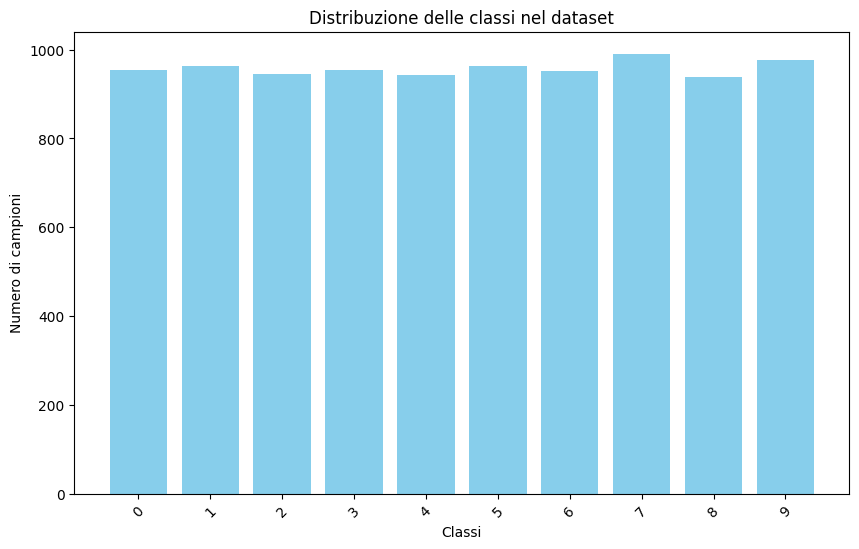

In [ ]:
# Visualizza la distribuzione delle classi nel training set
def plot_class_distribution(y):
    class_counts = Counter(y)
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classi')
    plt.ylabel('Numero di campioni')
    plt.title('Distribuzione delle classi nel dataset')
    plt.xticks(classes, rotation=45)
    plt.show()

plot_class_distribution(y_train)

#CLASSIFICATION CON CROP FILES

#Svm crop

In questo segmento di codice viene eseguita una ricerca a griglia per ottimizzare i parametri di un modello Support Vector Machine (SVM) con kernel RBF, utilizzando la cross-validation tramite StratifiedKFold per garantire una valutazione robusta e bilanciata. Viene quindi identificato il miglior modello in base ai parametri ottimali di C e gamma. Successivamente, vengono effettuate le predizioni sui set di addestramento e di test, e calcolate le metriche di performance, inclusa la matrice di confusione e il classification report, per valutare l'efficacia del modello.

In [ ]:
def plot_cm(model_name, y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# Parametri da testare con valori più bassi per C e gamma
param_grid = {'C': [1, 10, 50, 100, 200, 300, 1000],
              'gamma': [0.001, 0.01, 0.1, 1]}

clf = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid, cv=StratifiedKFold(n_splits=3))

t0 = time.time()
clf.fit(X_train, y_train)
print(f'Training completed in {time.time() - t0:.3f}s')

#miglior modello
best_model = clf.best_estimator_
best_score = clf.best_score_
print(f'Best model found with score: {best_score:.3f}')
print(f'Best parameters: C={best_model.C}, gamma={best_model.gamma}')

joblib.dump(best_model, 'best_svm_model.pkl')
print('Best SVM model saved as best_svm_model.pkl')



Training completed in 1028.394s
Best model found with score: 0.884
Best parameters: C=10, gamma=0.1
Best SVM model saved as best_svm_model.pkl


Training Accuracy: 0.9993736951983299
Classification Report for Best SVM Model:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       246
           1       0.95      0.97      0.96       237
           2       0.91      0.86      0.88       244
           3       0.94      0.89      0.92       245
           4       0.89      0.91      0.90       257
           5       0.95      0.92      0.93       224
           6       0.97      0.91      0.94       248
           7       0.80      0.95      0.87       209
           8       0.90      0.91      0.90       262
           9       0.88      0.86      0.87       224

    accuracy                           0.91      2396
   macro avg       0.91      0.91      0.91      2396
weighted avg       0.91      0.91      0.91      2396

Confusion Matrix for Best SVM Model:


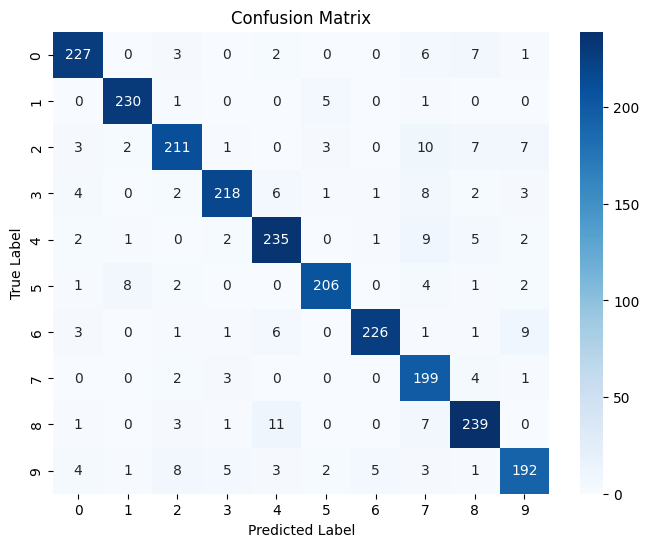

In [ ]:
best_svm_model = joblib.load('best_svm_model.pkl')

# Make predictions on the test set
y_pred_test = best_svm_model.predict(X_test)
y_train_pred = best_svm_model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

#Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
cr = classification_report(y_test, y_pred_test)

#Classification report
print("Classification Report for Best SVM Model:")
print(cr)
print("Confusion Matrix for Best SVM Model:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


#Random forest crop

In questo segmento di codice viene definito un grid search per ottimizzare i parametri del modello Random Forest. Il modello viene addestrato sui dati di addestramento, i migliori parametri vengono selezionati, e successivamente viene valutata la performance sia sui dati di addestramento che su quelli di test, con la stampa di un report di classificazione e la visualizzazione della matrice di confusione. Infine, il modello migliore viene salvato su disco.

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters found:  {'bootstrap': False, 'criterion': 'gini', 'max_features': 10, 'n_estimators': 300}
Random Forest Training Accuracy: 0.99937

Classification Report:
              precision    recall  f1-score   support

       blues       0.89      0.89      0.89       246
   classical       0.95      0.95      0.95       237
     country       0.83      0.87      0.85       244
       disco       0.89      0.84      0.87       245
      hiphop       0.92      0.87      0.89       257
        jazz       0.85      0.90      0.87       224
       metal       0.91      0.89      0.90       248
         pop       0.88      0.89      0.88       209
      reggae       0.87      0.91      0.89       262
        rock       0.81      0.78      0.79       224

    accuracy                           0.88      2396
   macro avg       0.88      0.88      0.88      2396
weighted avg       0.88      0.88      0.88      2396



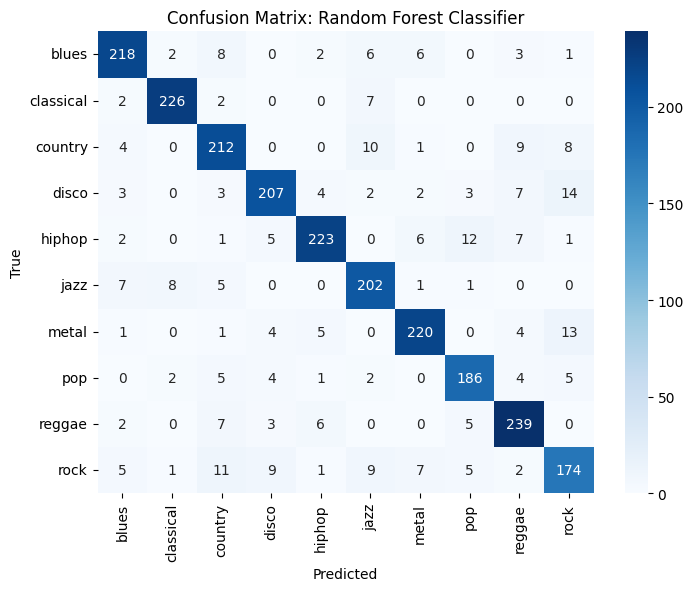

Random Forest model saved as random_forest_model.pkl


In [ ]:
# Define the parameter grid
rf_param_grid = {
    'max_features': [1, 3, 10],
    'bootstrap': [False],
    'n_estimators': [100, 200, 300],
    'criterion': ['gini']
}


rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid=rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)
l
best_rf = grid_search_rf.best_estimator_
print("Best parameters found: ", grid_search_rf.best_params_)

y_train_pred = best_rf.predict(X_train)
print(f"Random Forest Training Accuracy: {best_rf.score(X_train, y_train):.5f}\n")

y_test_pred = best_rf.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=GENRES))

#confusion matrix
plot_cm('Random Forest Classifier', y_test, y_test_pred, GENRES)

joblib.dump(best_rf, 'random_forest_model.pkl')
print('Random Forest model saved as random_forest_model.pkl')


#Knn crop

In questo segmento di codice, viene eseguita l'ottimizzazione iperparametrica per il modello K-Nearest Neighbors (KNN) utilizzando la ricerca su griglia (GridSearchCV). Viene definito un grid di parametri per esplorare diverse configurazioni di vicini, pesi e metriche di distanza, quindi il modello viene addestrato, valutato e salvato per un uso successivo.

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
KNN Training Accuracy: 0.99937

Classification Report:
              precision    recall  f1-score   support

       blues       0.95      0.87      0.90       246
   classical       0.94      0.97      0.95       237
     country       0.87      0.82      0.84       244
       disco       0.87      0.89      0.88       245
      hiphop       0.94      0.86      0.90       257
        jazz       0.84      0.90      0.87       224
       metal       0.95      0.91      0.93       248
         pop       0.89      0.89      0.89       209
      reggae       0.89      0.91      0.90       262
        rock       0.77      0.87      0.82       224

    accuracy                           0.89      2396
   macro avg       0.89      0.89      0.89      2396
weighted avg       0.89      0.89      0.89      2396



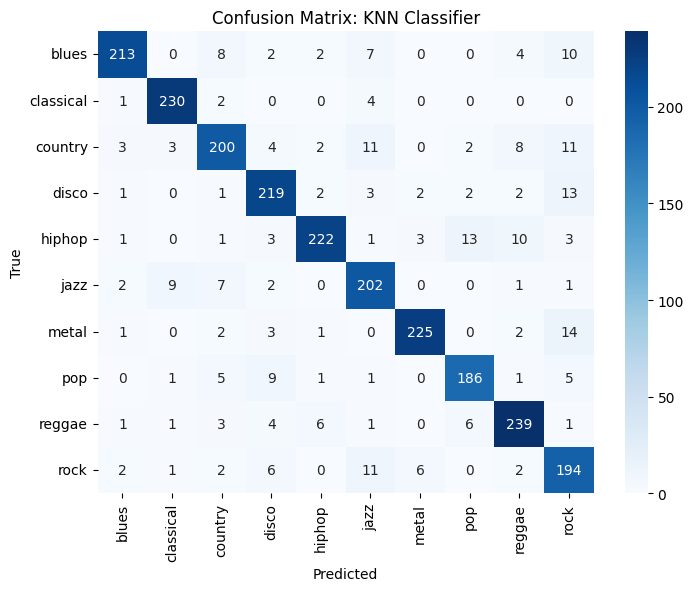

KNN model saved as knn_model.pkl


In [ ]:
# Parameter grid for KNN
knn_param_grid = {
    'n_neighbors': np.linspace(10,15,20, dtype=int).tolist(),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid=knn_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train, y_train)


best_knn = grid_search_knn.best_estimator_
print("Best parameters found: ", grid_search_knn.best_params_)

y_train_pred = best_knn.predict(X_train)
print(f"KNN Training Accuracy: {best_knn.score(X_train, y_train):.5f}\n")

y_test_pred = best_knn.predict(X_test)

# classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=GENRES))

# confusion matrix
plot_cm('KNN Classifier', y_test, y_test_pred, GENRES)

joblib.dump(best_knn, 'knn_model.pkl')
print('KNN model saved as knn_model.pkl')

#Xgboost crop

In questo segmento di codice viene configurato e addestrato un classificatore XGBoost con parametri specifici. Dopo aver allenato il modello, vengono effettuate le predizioni sui dati di test, calcolata l'accuratezza e generato un report di classificazione. Inoltre, la matrice di confusione viene visualizzata e il modello allenato viene salvato per un utilizzo futuro.

Accuracy: 0.89274 

Classification Report:
              precision    recall  f1-score   support

       blues       0.91      0.87      0.89       246
   classical       0.95      0.95      0.95       237
     country       0.81      0.85      0.83       244
       disco       0.91      0.89      0.90       245
      hiphop       0.94      0.90      0.92       257
        jazz       0.88      0.91      0.89       224
       metal       0.91      0.90      0.90       248
         pop       0.93      0.90      0.92       209
      reggae       0.89      0.91      0.90       262
        rock       0.80      0.84      0.82       224

    accuracy                           0.89      2396
   macro avg       0.89      0.89      0.89      2396
weighted avg       0.89      0.89      0.89      2396



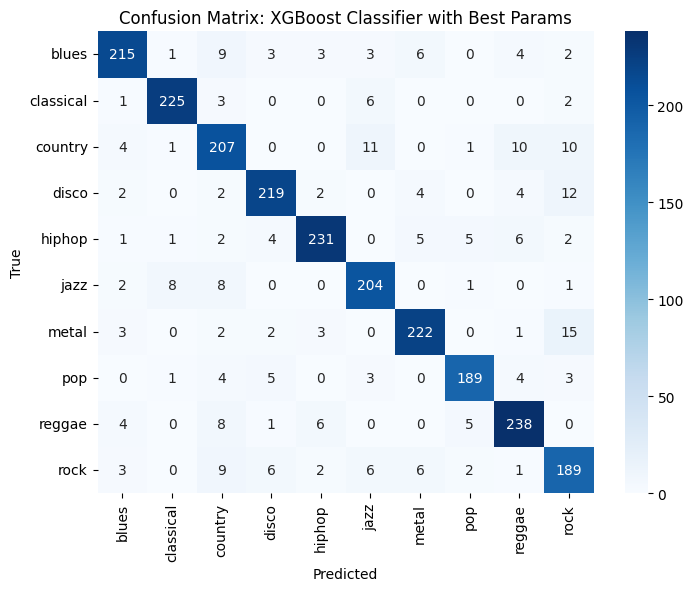

Best XGBoost model saved as xgboost_best_model.pkl


In [ ]:
# Parametri da testare
params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6
}

xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)

print('Accuracy:', round(accuracy_score(y_test, preds), 5), '\n')

#Classification report
print("Classification Report:")
print(classification_report(y_test, preds, target_names=GENRES))

plot_cm("XGBoost Classifier with Best Params", y_test, preds, GENRES)

joblib.dump(xgb, 'xgboost_best_model.pkl')
print('Best XGBoost model saved as xgboost_best_model.pkl')


#Ensemble Model crop

Questo segmento di codice carica i modelli di classificazione già addestrati (SVM, Random Forest e KNN) e li combina in un Voting Classifier, utilizzando un approccio di "voting" per fare previsioni. Il parametro voting='soft' indica che il Voting Classifier utilizza le probabilità predette da ciascun modello per determinare la classe finale, invece di utilizzare semplicemente la previsione di ciascun modello (come accadrebbe con voting='hard'). Questo approccio "soft" tende a essere più accurato in quanto tiene conto della confidenza di ciascun modello. Il Voting Classifier viene addestrato sui dati di addestramento, testato sui dati di test, e il risultato viene valutato tramite un classification report e una matrice di confusione. Infine, il modello finale viene salvato per un uso successivo.

Classification Report for Voting Classifier:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       246
           1       0.97      0.97      0.97       237
           2       0.91      0.89      0.90       244
           3       0.92      0.94      0.93       245
           4       0.96      0.93      0.94       257
           5       0.92      0.94      0.93       224
           6       0.97      0.92      0.95       248
           7       0.91      0.93      0.92       209
           8       0.91      0.92      0.91       262
           9       0.85      0.89      0.87       224

    accuracy                           0.93      2396
   macro avg       0.93      0.93      0.93      2396
weighted avg       0.93      0.93      0.93      2396



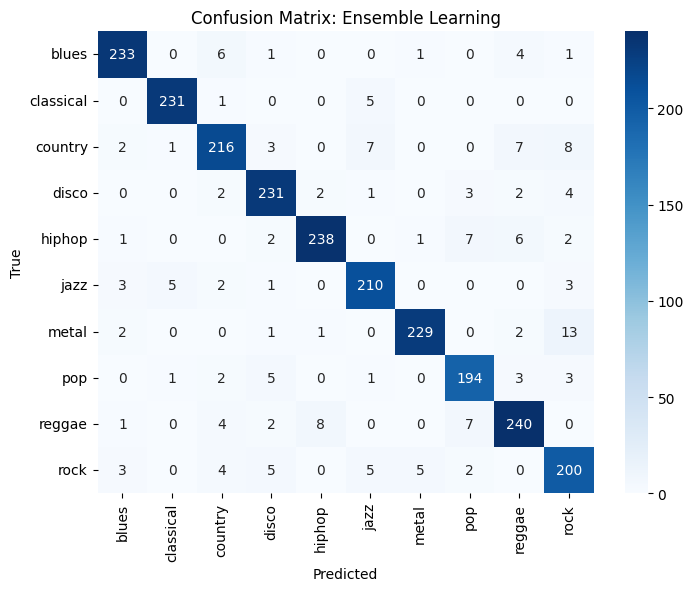

Voting Classifier model saved as voting_classifier_model.pkl


In [ ]:
# Carica i modelli salvati
svm_model = joblib.load('best_svm_model.pkl')
rf_model = joblib.load('random_forest_model.pkl')
knn_model = joblib.load('knn_model.pkl')

# Crea il Voting Classifier
voting_c = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('rfc', rf_model),
        ('knn', knn_model)
    ],
    voting='soft',
    n_jobs=-1
)

voting_c.fit(X_train, y_train)

y_prediction = voting_c.predict(X_test)

# Classification Report
print("Classification Report for Voting Classifier:")
print(classification_report(y_test, y_prediction))

# Confusion matrix
plot_cm('Ensemble Learning', y_test, y_prediction, GENRES)

joblib.dump(voting_c, 'voting_classifier_model.pkl')
print('Voting Classifier model saved as voting_classifier_model.pkl')




#Neural network crop

Questo segmento di codice definisce e addestra una rete neurale per la classificazione dei generi musicali. La rete è composta da:

* Input Layer: Un layer Flatten che trasforma l'input 2D in un vettore 1D di dimensione 39.
* Hidden Layers: Quattro layer Dense con attivazione ReLU, che operano su diverse dimensioni di unità (256, 128, 64, 64 o 128, a seconda dell'ottimizzazione dei parametri). Viene utilizzato il dropout del 25% per ridurre l'overfitting.
* Output Layer: Un layer Dense con 10 unità e attivazione softmax per classificare tra 10 generi musicali.
* Il modello viene compilato con la funzione di perdita sparse categorical crossentropy e l'ottimizzatore Adam. Per ottimizzare l'architettura, viene usato Keras Tuner che esplora diverse combinazioni di unità nei layer nascosti.

Il miglior modello viene addestrato per 50 epoche e salvato. Successivamente, le prestazioni vengono valutate con una matrice di confusione e un report di classificazione.

In [ ]:
#Rieseguire per sicurezza
X_train_crop = np.array(X_train, dtype=np.float32)
X_test_crop = np.array(X_test, dtype=np.float32)
y_train_crop = np.array(y_train, dtype=np.int32)
y_test_crop = np.array(y_test, dtype=np.int32)

In [ ]:
model = Sequential()
model.add(layers.Flatten(input_shape = (39,)))
model.add(layers.Dense(256, activation ='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation ='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation ='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation ='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 39)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          10,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,042 (203.29 KB)

 Trainable params: 52,042 (203.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=  'adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x = X_train_crop, y = y_train_crop, validation_data=(X_test_crop, y_test_crop), epochs=100)

Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3797 - loss: 1.7480 - val_accuracy: 0.6256 - val_loss: 1.0396
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6094 - loss: 1.1218 - val_accuracy: 0.7120 - val_loss: 0.8477
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6547 - loss: 0.9748 - val_accuracy: 0.7237 - val_loss: 0.7928
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6896 - loss: 0.8757 - val_accuracy: 0.7442 - val_loss: 0.7358
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7193 - loss: 0.8102 - val_accuracy: 0.7629 - val_loss: 0.6600
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7381 - loss: 0.7690 - val_accuracy: 0.7813 - val_loss: 0.6322
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7540 - loss: 0.7095 - val_accuracy: 0.7913 - val_loss: 0.5938
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7678 - loss: 0.6886 - val_accu

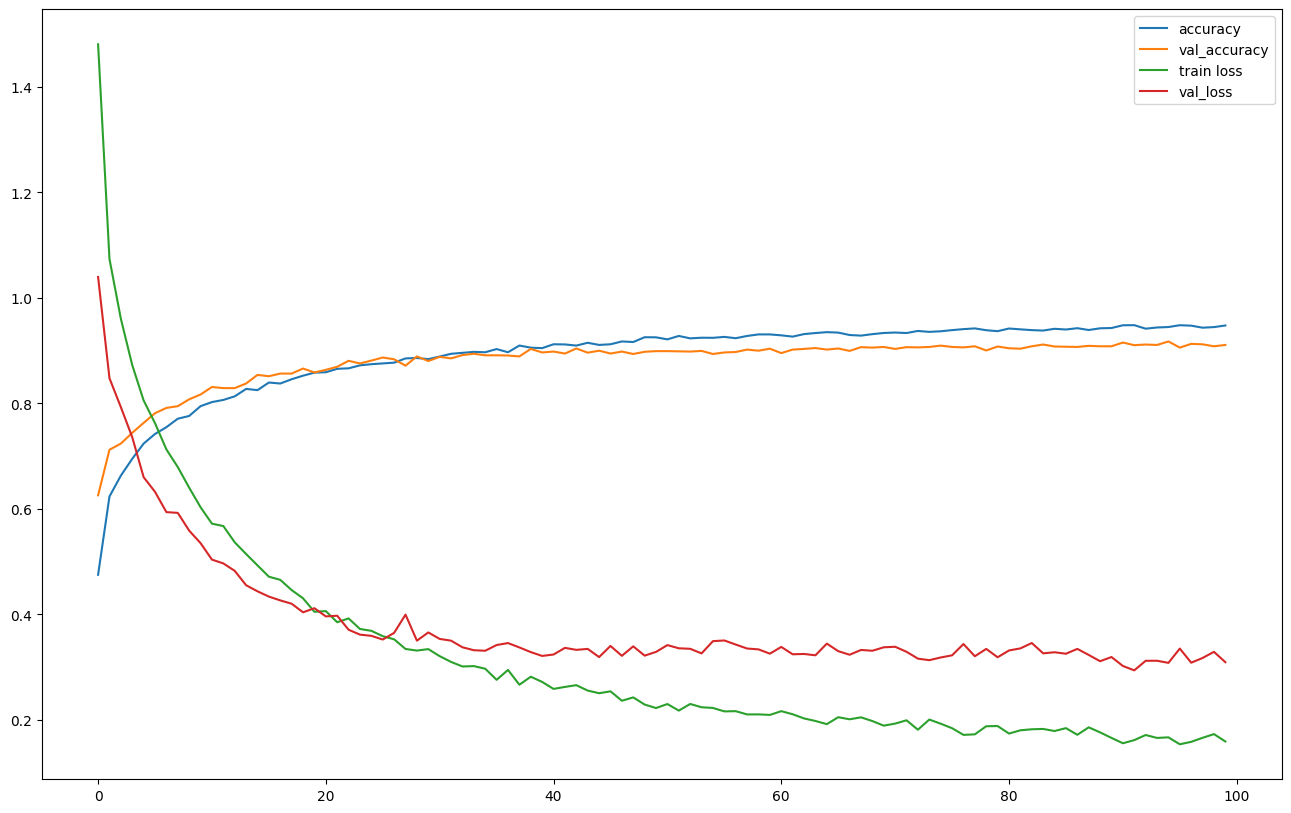

In [ ]:
plt.figure(figsize = (16, 10))
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [ ]:
# model for keras tuner
def build_model(hp):
    model = Sequential()
    model.add(layers.Flatten(input_shape = (39,)))
    model.add(layers.Dense(units = hp.Choice('dense_1', [256,512]), activation= "relu"))
    model.add(layers.Dropout(0.25))

    model.add(layers.Dense(units = hp.Choice('dense_2',[128,256]), activation= "relu"))
    model.add(layers.Dropout(0.25))

    model.add(layers.Dense(units = hp.Choice('dense_3',[64,128]), activation= "relu"))
    model.add(layers.Dropout(0.25))

    model.add(layers.Dense(units = hp.Choice('dense_4',[64,128]), activation= "relu"))

    model.add(layers.Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
dense_1 (Choice)
{'default': 256, 'conditions': [], 'values': [256, 512], 'ordered': True}
dense_2 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256], 'ordered': True}
dense_3 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
dense_4 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}


In [ ]:
tuner.search(X_train_crop, y_train_crop, epochs=5, validation_data=(X_test_crop, y_test_crop))

Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.7934056520462036

Best val_accuracy So Far: 0.8138564229011536
Total elapsed time: 00h 01m 56s


In [ ]:
tuner.search(X_train_crop, y_train_crop, epochs=5, validation_data=(X_test_crop, y_test_crop))

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_history = best_model.fit(X_train_crop, y_train_crop, validation_data=(X_test_crop, y_test_crop), epochs=50)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7940 - loss: 0.6019 - val_accuracy: 0.8205 - val_loss: 0.5405
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8191 - loss: 0.5226 - val_accuracy: 0.8285 - val_loss: 0.5150
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8374 - loss: 0.4797 - val_accuracy: 0.8368 - val_loss: 0.4976
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8323 - loss: 0.4768 - val_accuracy: 0.8381 - val_loss: 0.4920
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8578 - loss: 0.4166 - val_accuracy: 0.8497 - val_loss: 0.4385
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8650 - loss: 0.3919 - val_accuracy: 0.8639 - val_loss: 0.4166
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8700 - loss: 0.3661 - val_accuracy: 0.8673 - val_loss: 0.4064
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8832 - loss: 0.3335 - val_accuracy: 0.8715 - val_

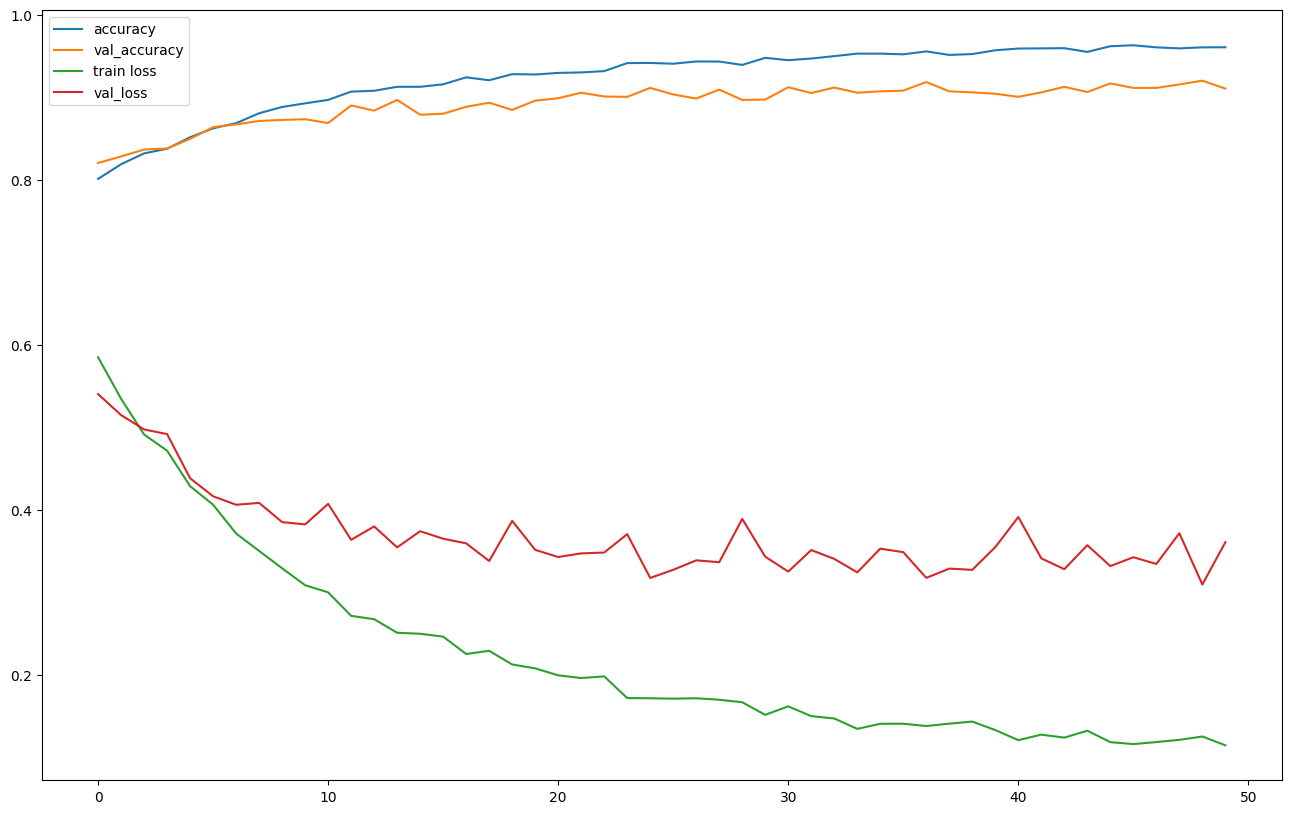

In [ ]:
plt.figure(figsize = (16, 10))
plt.plot(best_history.history['accuracy'], label = 'accuracy')
plt.plot(best_history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(best_history.history['loss'], label = 'train loss')
plt.plot(best_history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

Best Neural Network model saved as best_nn_model.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


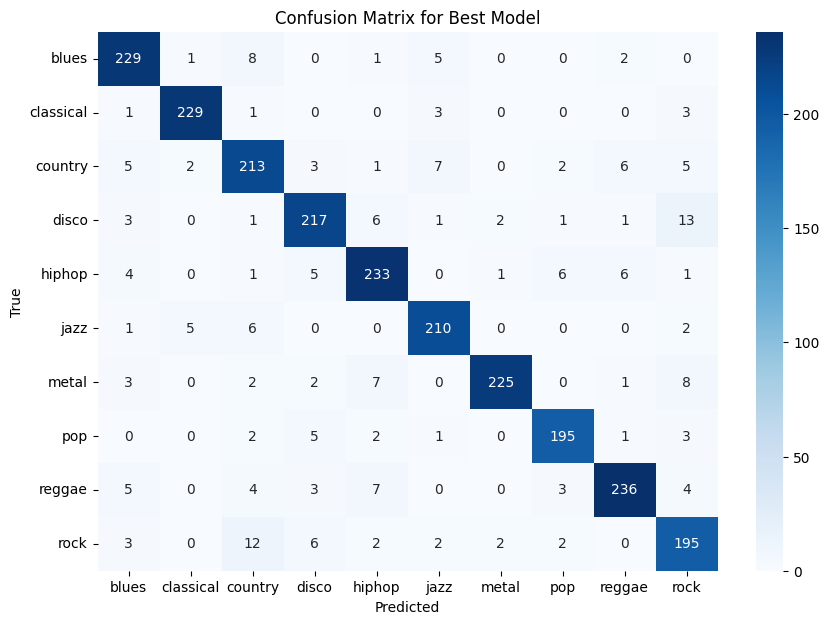

Classification Report:
              precision    recall  f1-score   support

       blues       0.90      0.93      0.92       246
   classical       0.97      0.97      0.97       237
     country       0.85      0.87      0.86       244
       disco       0.90      0.89      0.89       245
      hiphop       0.90      0.91      0.90       257
        jazz       0.92      0.94      0.93       224
       metal       0.98      0.91      0.94       248
         pop       0.93      0.93      0.93       209
      reggae       0.93      0.90      0.92       262
        rock       0.83      0.87      0.85       224

    accuracy                           0.91      2396
   macro avg       0.91      0.91      0.91      2396
weighted avg       0.91      0.91      0.91      2396



In [ ]:
model.save("/content/best_nn_model.h5")
print('Best Neural Network model saved as best_nn_model.h5')


y_test_pred = best_model.predict(X_test_crop)
y_test_pred = np.argmax(y_test_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_crop, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=GENRES, yticklabels=GENRES)
plt.title('Confusion Matrix for Best Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#Classification report
print("Classification Report:")
print(classification_report(y_test_crop, y_test_pred, target_names=GENRES))


#CLASSIFICATION CON DATA AUMENTATI

In questo segmento di codice si prova ad aumentare i dati aggiungendo rumore. Avremo così il doppio dei dati in quanto per ogni crop, terremo sia l'audio originale sia la versione con rumore. Si ripetono poi tutti i passaggi spiegati in precedenza con i classificatori per i dati crop.

#Fare augmentation (rumore)

In [ ]:
signal = y.astype(np.float32)

# Test con diversi livelli di rumore
for noise_level in [0.001, 0.005, 0.01, 0.02]:
    noise = np.random.normal(0, noise_level * np.max(signal), signal.shape)
    noisy_signal = signal + noise

    snr = 10 * np.log10(np.mean(signal**2) / np.mean(noise**2))
    print(f"Noise Level: {noise_level} -> SNR: {snr:.2f} dB")

Noise Level: 0.001 -> SNR: 44.01 dB
Noise Level: 0.005 -> SNR: 30.05 dB
Noise Level: 0.01 -> SNR: 24.02 dB
Noise Level: 0.02 -> SNR: 18.01 dB


In [ ]:
def add_noise(audio, rate, noise_level=0.02):
    audio = audio.astype(np.float32)
    noise = np.random.normal(0, noise_level * np.max(audio), audio.shape)
    noisy_audio = audio + noise
    noisy_audio = np.clip(noisy_audio, -32768, 32767).astype(np.int16)

    return noisy_audio


def apply_augmentation_to_crops(path, dest_path, GENRES):
    if not os.path.exists(dest_path):
        print(f"Creazione della cartella di destinazione: {dest_path}")
        os.makedirs(dest_path, exist_ok=True)

    for genre in GENRES:
        genre_path = os.path.join(path, genre)
        genre_dest_path = os.path.join(dest_path, genre)

        if not os.path.exists(genre_dest_path):
            print(f"Creazione della cartella per il genere: {genre_dest_path}")
            os.makedirs(genre_dest_path, exist_ok=True)

        for f in sorted(os.listdir(genre_path)):
            if f.endswith('.wav'):
                try:
                    rate, signal = wavfile.read(os.path.join(genre_path, f))
                    if signal is None or len(signal) == 0:
                        print(f"File vuoto o non valido: {f}")
                        continue
                    original_filename = os.path.join(genre_dest_path, f)
                    augmented_filename = os.path.join(genre_dest_path, f[:-4] + f'_aug_noise.wav')

                    augmented_dir = os.path.dirname(augmented_filename)
                    if not os.path.exists(augmented_dir):
                        print(f"Creazione della cartella per il file aumentato: {augmented_dir}")
                        os.makedirs(augmented_dir, exist_ok=True)

                    if not os.path.exists(original_filename):
                        wavfile.write(original_filename, rate, signal)
                        print(f"File originale salvato come: {original_filename}")

                    noisy_data = add_noise(signal, rate)
                    wavfile.write(augmented_filename, rate, noisy_data)
                    print(f"File aumentato salvato come: {augmented_filename}")

                except Exception as e:
                    print(f"Errore nel file {f}: {e}")
                    continue

output_dir = "/content/gdrive/MyDrive/Digital progetto/Data/data_crop"
augmented_output_dir = "/content/gdrive/MyDrive/Digital progetto/Data/augmented"
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

apply_augmentation_to_crops(output_dir, augmented_output_dir, GENRES)




Output streaming troncato alle ultime 5000 righe.
File originale salvato come: /content/gdrive/MyDrive/Digital progetto/Data/augmented/pop/pop.00091_crop_7.wav
File aumentato salvato come: /content/gdrive/MyDrive/Digital progetto/Data/augmented/pop/pop.00091_crop_7_aug_noise.wav
File originale salvato come: /content/gdrive/MyDrive/Digital progetto/Data/augmented/pop/pop.00091_crop_8.wav
File aumentato salvato come: /content/gdrive/MyDrive/Digital progetto/Data/augmented/pop/pop.00091_crop_8_aug_noise.wav
File originale salvato come: /content/gdrive/MyDrive/Digital progetto/Data/augmented/pop/pop.00091_crop_9.wav
File aumentato salvato come: /content/gdrive/MyDrive/Digital progetto/Data/augmented/pop/pop.00091_crop_9_aug_noise.wav
File originale salvato come: /content/gdrive/MyDrive/Digital progetto/Data/augmented/pop/pop.00092_crop_0.wav
File aumentato salvato come: /content/gdrive/MyDrive/Digital progetto/Data/augmented/pop/pop.00092_crop_0_aug_noise.wav
File originale salvato come: /

#Visualizzazione dati aumentati

In [ ]:
random_file_name = "/content/gdrive/MyDrive/Digital progetto/Data/augmented/blues/blues.00000_crop_0_aug_noise.wav"
y,sr = librosa.load(random_file_name,sr=None)

In [ ]:
Audio(data=y,rate=sr)

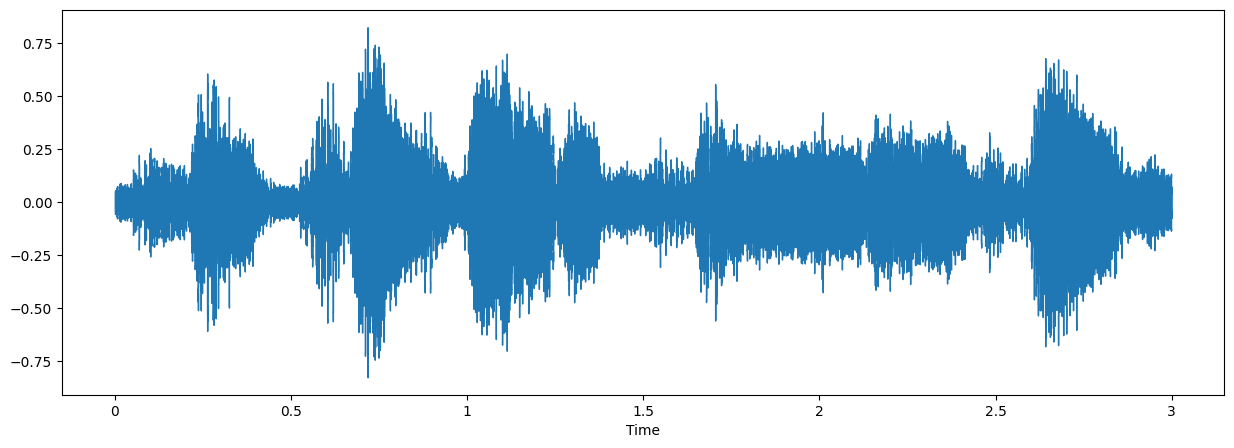

In [ ]:
plt.figure(figsize=(15,5))
librosa.display.waveshow(y,sr=sr)

Frequenza di campionamento: 22050 Hz
RMSE tra il segnale originale e quello rumoroso: 0.0117


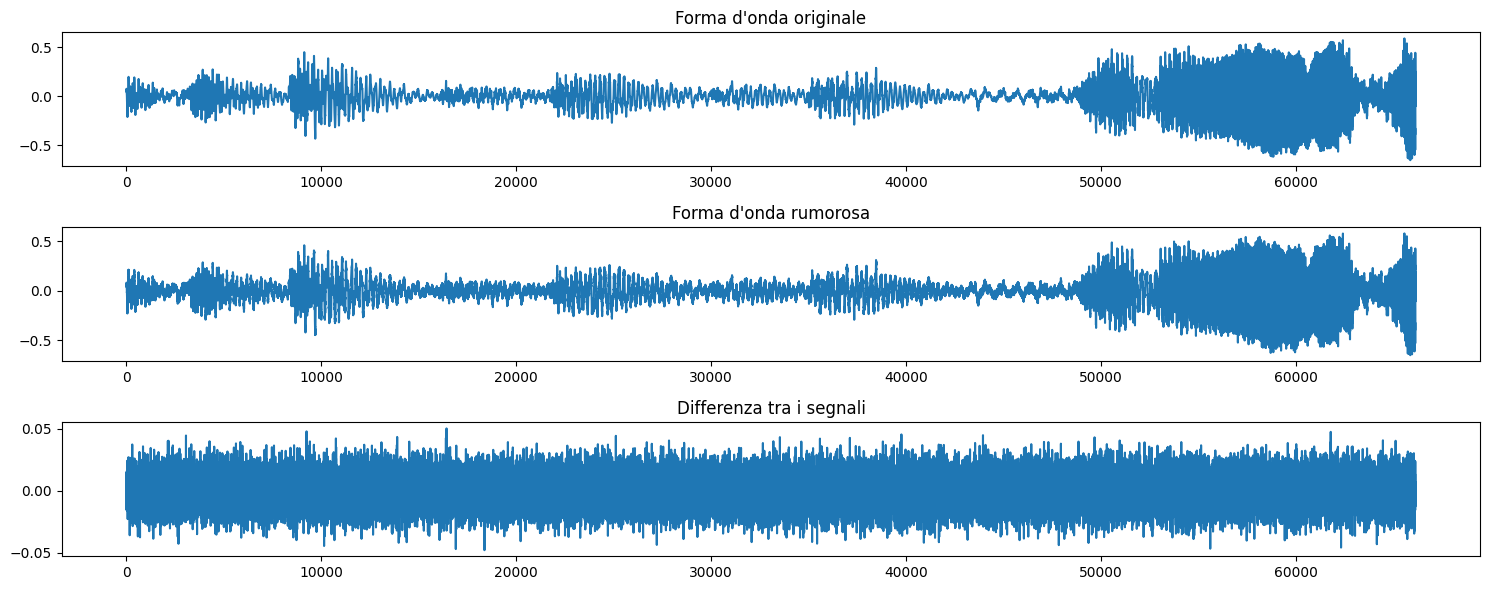

In [ ]:
# Carica i file audio
noisy_file = "/content/gdrive/MyDrive/Digital progetto/Data/augmented/blues/blues.00021_crop_0_aug_noise.wav"
original_file = "/content/gdrive/MyDrive/Digital progetto/Data/data_crop/blues/blues.00021_crop_0.wav"

y_noisy, sr_noisy = librosa.load(noisy_file, sr=None)
y_original, sr_original = librosa.load(original_file, sr=None)

# Verifica che le frequenze di campionamento siano uguali
if sr_noisy != sr_original:
    print(f"Le frequenze di campionamento sono diverse: {sr_noisy} vs {sr_original}")
else:
    print(f"Frequenza di campionamento: {sr_noisy} Hz")

# Calcola la differenza tra i due segnali
difference = y_noisy - y_original

# Calcola l'errore quadratico medio (RMSE)
rmse = np.sqrt(mean_squared_error(y_original, y_noisy))
print(f"RMSE tra il segnale originale e quello rumoroso: {rmse:.4f}")

# Visualizza le forme d'onda
plt.figure(figsize=(15, 6))

# Forma d'onda originale
plt.subplot(3, 1, 1)
plt.plot(y_original)
plt.title("Forma d'onda originale")

# Forma d'onda rumorosa
plt.subplot(3, 1, 2)
plt.plot(y_noisy)
plt.title("Forma d'onda rumorosa")

# Differenza tra i segnali
plt.subplot(3, 1, 3)
plt.plot(difference)
plt.title("Differenza tra i segnali")

plt.tight_layout()
plt.show()


In [ ]:
def calculate_snr(y, noise_threshold=0.01):
    # Estrazione del rumore come la parte a bassa energia
    noise = y[:int(len(y) * 0.1)]  # Prendi la prima parte del segnale (ad esempio il silenzio iniziale)
    signal_power = np.mean(y ** 2)
    noise_power = np.mean(noise ** 2) if len(noise) > 0 else 1e-10  # Evita la divisione per zero
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Calcola il SNR
snr_value = calculate_snr(y)
print(f"SNR: {snr_value:.2f} dB")

# Soglia indicativa: SNR < 20 dB → probabile rumore
if snr_value < 20:
    print("Rumore presente")
else:
    print("File pulito.")

SNR: 1.99 dB
Rumore presente


#Loader

In [ ]:
DATASET_PATH = "/content/gdrive/MyDrive/Digital progetto/Data/augmented"
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

X_train_aug, X_test_aug, y_train_aug, y_test_aug = load_data_in_batches(DATASET_PATH, GENRES, extract_features)

# Normalize
scaler_aug = StandardScaler()

joblib.dump(scaler_aug, "scaler_aug.pkl")
joblib.dump(X_train_aug, "X_train_aug.pkl")
joblib.dump(X_test_aug, "X_test_aug.pkl")
joblib.dump(y_train_aug, "y_train_aug.pkl")
joblib.dump(y_test_aug, "y_test_aug.pkl")
# Verifica delle dimensioni
print(f"X_train shape: {X_train_aug.shape}")
print(f"X_test shape: {X_test_aug.shape}")
print(f"y_train_aug shape: {len(y_train_aug)}")
print(f"y_test_aug shape: {len(y_test_aug)}")

Caricando classe: blues (0), files 0 - 50
File: blues.00000_crop_0.wav - Classe: blues (0)


<ipython-input-34-33bab4a26b34>:23: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  librosa.beat.tempo(y=y, sr=sr)[0],  # tempo


Output streaming troncato alle ultime 5000 righe.
File: pop.00095_crop_8_aug_noise.wav - Classe: pop (7)
File: pop.00095_crop_9.wav - Classe: pop (7)
File: pop.00095_crop_9_aug_noise.wav - Classe: pop (7)
File: pop.00096_crop_0.wav - Classe: pop (7)
File: pop.00096_crop_0_aug_noise.wav - Classe: pop (7)
File: pop.00096_crop_1.wav - Classe: pop (7)
File: pop.00096_crop_10.wav - Classe: pop (7)
File: pop.00096_crop_10_aug_noise.wav - Classe: pop (7)
File: pop.00096_crop_11.wav - Classe: pop (7)
File: pop.00096_crop_11_aug_noise.wav - Classe: pop (7)
File: pop.00096_crop_1_aug_noise.wav - Classe: pop (7)
File: pop.00096_crop_2.wav - Classe: pop (7)
File: pop.00096_crop_2_aug_noise.wav - Classe: pop (7)
File: pop.00096_crop_3.wav - Classe: pop (7)
File: pop.00096_crop_3_aug_noise.wav - Classe: pop (7)
File: pop.00096_crop_4.wav - Classe: pop (7)
File: pop.00096_crop_4_aug_noise.wav - Classe: pop (7)
File: pop.00096_crop_5.wav - Classe: pop (7)
File: pop.00096_crop_5_aug_noise.wav - Classe:

oppure se si hanno già

In [ ]:
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
# Caricare scaler
scaler_aug = joblib.load("/content/scaler (3).pkl")

# Caricare i dati normalizzati
X_train_aug = joblib.load("/content/X_train_aug (2).pkl")
X_test_aug = joblib.load("/content/X_test_aug (2).pkl")
y_train_aug = joblib.load("/content/y_train_aug (2).pkl")
y_test_aug = joblib.load("/content/y_test_aug (2).pkl")

# Verifica delle dimensioni
print(f"X_train shape: {X_train_aug.shape}")
print(f"X_test shape: {X_test_aug.shape}")
print(f"y_train_aug shape: {len(y_train_aug)}")
print(f"y_test_aug shape: {len(y_test_aug)}")

X_train shape: (15968, 39)
X_test shape: (3992, 39)
y_train_aug shape: 15968
y_test_aug shape: 3992


#Random forest augmentation

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters found:  {'bootstrap': False, 'criterion': 'gini', 'max_features': 10, 'n_estimators': 300}
Random Forest Training Accuracy: 0.99962

Classification Report for Random Forest:
              precision    recall  f1-score   support

       blues       0.87      0.85      0.86       355
   classical       0.94      0.97      0.95       429
     country       0.78      0.84      0.81       392
       disco       0.86      0.88      0.87       398
      hiphop       0.92      0.90      0.91       427
        jazz       0.87      0.91      0.89       384
       metal       0.92      0.94      0.93       407
         pop       0.94      0.90      0.92       413
      reggae       0.88      0.87      0.87       395
        rock       0.86      0.75      0.80       392

    accuracy                           0.88      3992
   macro avg       0.88      0.88      0.88      3992
weighted avg       0.88      0.88      0.88    

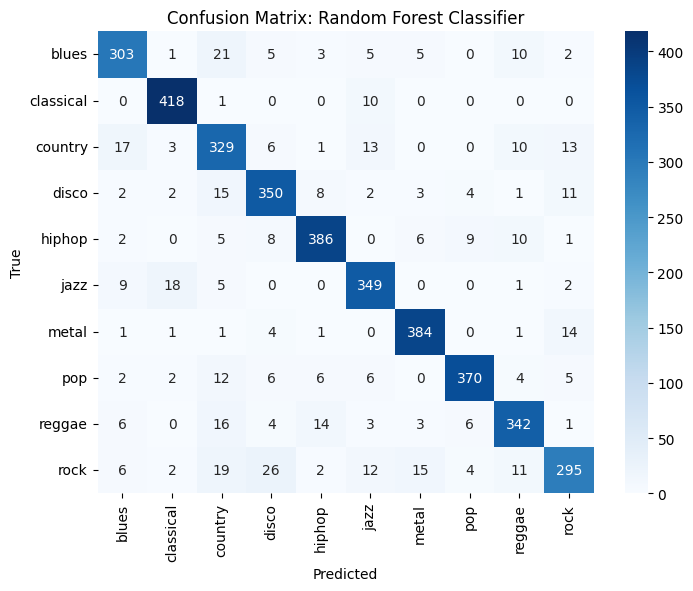

Random Forest model saved as rf_model_aug.pkl


In [ ]:
# Parameter grid for Random Forest
rf_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [300],
    'bootstrap': [False],
    'max_features': [10],
}

rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf, param_grid=rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_aug, y_train_aug)

best_rf = grid_search_rf.best_estimator_

print("Best parameters found: ", grid_search_rf.best_params_)

y_train_pred_rf = best_rf.predict(X_train_aug)
print(f"Random Forest Training Accuracy: {best_rf.score(X_train_aug, y_train_aug):.5f}\n")

y_test_pred_rf = best_rf.predict(X_test_aug)

# Print classification report
print("Classification Report for Random Forest:")
print(classification_report(y_test_aug, y_test_pred_rf, target_names=GENRES))

# Plot confusion matrix
plot_cm('Random Forest Classifier', y_test_aug, y_test_pred_rf, GENRES)

joblib.dump(best_rf, 'rf_model_aug.pkl')
print('Random Forest model saved as rf_model_aug.pkl')


#KNN augmentation

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
KNN Training Accuracy: 0.99962

Classification Report:
              precision    recall  f1-score   support

       blues       0.18      0.15      0.16       355
   classical       0.55      0.53      0.54       429
     country       0.19      0.16      0.17       392
       disco       0.20      0.21      0.20       398
      hiphop       0.18      0.16      0.17       427
        jazz       0.25      0.23      0.24       384
       metal       0.41      0.53      0.46       407
         pop       0.34      0.41      0.37       413
      reggae       0.26      0.29      0.27       395
        rock       0.15      0.13      0.14       392

    accuracy                           0.28      3992
   macro avg       0.27      0.28      0.27      3992
weighted avg       0.27      0.28      0.28      3992



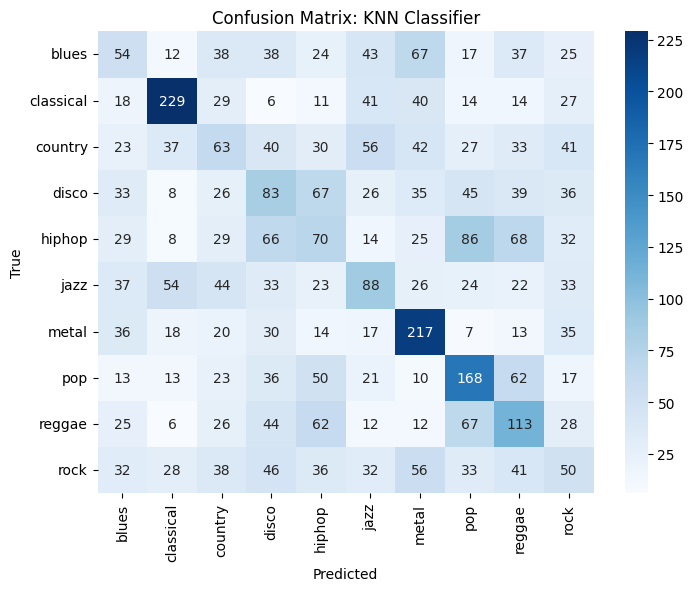

KNN model saved as knn_model_aug.pkl


In [ ]:

knn_param_grid = {
    'n_neighbors': [10],
    'weights': ['distance'],
    'metric': ['manhattan']
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid=knn_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train_aug, y_train_aug)

best_knn = grid_search_knn.best_estimator_

print("Best parameters found: ", grid_search_knn.best_params_)

y_train_pred = best_knn.predict(X_train_aug)
print(f"KNN Training Accuracy: {best_knn.score(X_train_aug, y_train_aug):.5f}\n")

y_test_pred = best_knn.predict(X_test_aug)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_aug, y_test_pred, target_names=GENRES))

# Plot confusion matrix
plot_cm('KNN Classifier', y_test_aug, y_test_pred, GENRES)

joblib.dump(best_knn, 'knn_model_aug.pkl')
print('KNN model saved as knn_model_aug.pkl')

Si nota come l'aggiunta di rumore non ha portato i risultati necessari sia a livello di accuracy sia a livello computazionale il processo risulti inefficente. In implementazioni future si proveranno tecniche di augmentation diverse.